Violin plots of wind by scenario

In [2]:
%reset
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import scendict as sc
import utils as ut
import netCDF4 as nc
import xarray as xr
import numpy as np
from importlib import reload
reload(sc)
reload(ut)

import cartopy as cp
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import glob
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

import time 
import pickle


import weighted
from matplotlib.cbook import violin_stats
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
def vdensity_with_weights(weights):
    ''' Outer function allows innder function access to weights. Matplotlib
    needs function to take in data and coords, so this seems like only way
    to 'pass' custom density function a set of weights '''
    
    def vdensity(data, coords):
        ''' Custom matplotlib weighted violin stats function '''
        # Using weights from closure, get KDE fomr statsmodels
        weighted_cost = sm.nonparametric.KDEUnivariate(data)
        weighted_cost.fit(fft=False, weights=weights)

        # Return y-values for graph of KDE by evaluating on coords
        return weighted_cost.evaluate(coords)
    return vdensity

def custom_violin_stats(data, weights):
    # Get weighted median and mean (using weighted module for median)
    median = weighted.quantile_1D(data, weights, 0.5)
    mean, sumw = np.ma.average(data, weights=list(weights), returned=True)
    
    # Use matplotlib violin_stats, which expects a function that takes in data and coords
    # which we get from closure above
    results = violin_stats(data, vdensity_with_weights(weights))
    #print(results)
    # Update result dictionary with our updated info
    results[0][u"mean"] = mean
    results[0][u"median"] = median
    
    # No need to do this, since it should be populated from violin_stats
    # results[0][u"min"] =  np.min(data)
    # results[0][u"max"] =  np.max(data)

    return results

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [5]:
SIZE = 100
x = np.random.normal(size=SIZE)
w = np.random.randint(1, 10, size=SIZE) * 1.
w[30:50] =0

vpstats_1A = custom_violin_stats(x+0, w)
tw = weighted_quantile([1, 2, 9, 3.2, 4], [0.5], sample_weight=[2, 1, 2, 4, 1])
print(tw)

[3.2]


In [6]:
vpstats_1A = custom_violin_stats(x+0, w)
vpstats_1B = custom_violin_stats(x+1, w)
vpstats_2A = custom_violin_stats(x+2, w)
vpstats_2B = custom_violin_stats(x+3, w)
vpstats_3A = custom_violin_stats(x+4, w)
vpstats_3B = custom_violin_stats(x+5, w)

[Text(0, 1.0, 'O$_3$ hist., CO$_2$ ↓ '),
 Text(0, 1.75, 'O$_3$ hist., CO$_2$ ↑'),
 Text(0, 3.0, 'O$_3$ ↑, CO$_2$ ↓'),
 Text(0, 3.75, 'O$_3$ ↑, CO$_2$ ↑'),
 Text(0, 5.0, 'O$_3$ ↓, CO$_2$ ↓'),
 Text(0, 5.75, 'O$_3$ ↓, CO$_2$ ↑')]

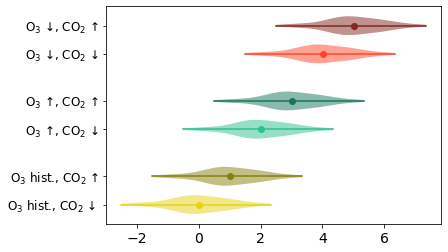

In [7]:
scens = ['1A','1B','2A','2B','3A','3B']
vpstats = [vpstats_1A,vpstats_1B,vpstats_2A,\
           vpstats_2B,vpstats_3A,vpstats_3B]
plcs = [[1],[1.75],[3],[3.75],[5],[5.75]]

fig, ax = plt.subplots()
for i in range(0,6):
    vpst = vpstats[i]
    plc = plcs[i]
    vplot = ax.violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    ax.plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'])
    ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
           color = sc.scen[scens[i]]['color'])
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        pc.set_alpha(0.5)

ax.set_yticks([1,1.75,3,3.75,5,5.75])
ax.set_yticklabels(['O$_3$ hist., CO$_2$ ↓ ',
                    'O$_3$ hist., CO$_2$ ↑',
                    'O$_3$ ↑, CO$_2$ ↓','O$_3$ ↑, CO$_2$ ↑',
                    'O$_3$ ↓, CO$_2$ ↓','O$_3$ ↓, CO$_2$ ↑'], \
                  fontsize = 12)
# ax.set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
#                     '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
#                     '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
#                   fontsize = 10)
# vplot = ax.violin(vpstats, [4], vert=False, showmeans=True, showextrema=True,
#                   showmedians=False)
# for pc in vplot['bodies']:
#     pc.set_facecolor('turquoise')
#     pc.set_alpha(0.8)

In [8]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
test_csize = tmesh.csize[0:37,:].values

def make_vpstats(scen,season,yrst,yrend):

    tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
    q = xr.open_dataset(tw)
    test_wspd = np.nanmean(q.mean_wspd[yrst:yrend,season,0:37,:].values, axis = 0)
    vpstats = custom_violin_stats(np.ravel(test_wspd), np.ravel(test_csize))
    p95=0
    p95 = weighted_quantile(np.ravel(test_wspd), [0.95], sample_weight = np.ravel(test_csize))
    return vpstats, p95

In [9]:
vpstats_1A_s_1950, p95_1A_s_1950 = make_vpstats('1A',12,0,20)

In [10]:
import time
ts = time.time()
print(ts)
#12 is summer, 13 is winter
vpstats_1A_s_1950, p95_1A_s_1950 = make_vpstats('1A',12,0,20)
vpstats_1B_s_1950, p95_1B_s_1950 = make_vpstats('1B',12,0,20)
vpstats_2A_s_1950, p95_2A_s_1950 = make_vpstats('2A',12,0,20)
vpstats_2B_s_1950, p95_2B_s_1950 = make_vpstats('2B',12,0,20)
vpstats_3A_s_1950, p95_3A_s_1950 = make_vpstats('3A',12,0,20)
vpstats_3B_s_1950, p95_3B_s_1950 = make_vpstats('3B',12,0,20)
##
vpstats_1A_w_1950, p95_1A_w_1950 = make_vpstats('1A',13,0,20)
vpstats_1B_w_1950, p95_1B_w_1950 = make_vpstats('1B',13,0,20)
vpstats_2A_w_1950, p95_2A_w_1950 = make_vpstats('2A',13,0,20)
vpstats_2B_w_1950, p95_2B_w_1950 = make_vpstats('2B',13,0,20)
vpstats_3A_w_1950, p95_3A_w_1950 = make_vpstats('3A',13,0,20)
vpstats_3B_w_1950, p95_3B_w_1950 = make_vpstats('3B',13,0,20)

vpstats_1A_s_2020, p95_1A_s_2020 = make_vpstats('1A',12,70,90)
vpstats_1B_s_2020, p95_1B_s_2020 = make_vpstats('1B',12,70,90)
vpstats_2A_s_2020, p95_2A_s_2020 = make_vpstats('2A',12,70,90)
vpstats_2B_s_2020, p95_2B_s_2020 = make_vpstats('2B',12,70,90)
vpstats_3A_s_2020, p95_3A_s_2020 = make_vpstats('3A',12,70,90)
vpstats_3B_s_2020, p95_3B_s_2020 = make_vpstats('3B',12,70,90)
##
vpstats_1A_w_2020, p95_1A_w_2020 = make_vpstats('1A',13,70,90)
vpstats_1B_w_2020, p95_1B_w_2020 = make_vpstats('1B',13,70,90)
vpstats_2A_w_2020, p95_2A_w_2020 = make_vpstats('2A',13,70,90)
vpstats_2B_w_2020, p95_2B_w_2020 = make_vpstats('2B',13,70,90)
vpstats_3A_w_2020, p95_3A_w_2020 = make_vpstats('3A',13,70,90)
vpstats_3B_w_2020, p95_3B_w_2020 = make_vpstats('3B',13,70,90)

vpstats_1A_s_2050, p95_1A_s_2050 = make_vpstats('1A',12,100,120)
vpstats_1B_s_2050, p95_1B_s_2050 = make_vpstats('1B',12,100,120)
vpstats_2A_s_2050, p95_2A_s_2050 = make_vpstats('2A',12,100,120)
vpstats_2B_s_2050, p95_2B_s_2050 = make_vpstats('2B',12,100,120)
vpstats_3A_s_2050, p95_3A_s_2050 = make_vpstats('3A',12,100,120)
vpstats_3B_s_2050, p95_3B_s_2050 = make_vpstats('3B',12,100,120)
##
vpstats_1A_w_2050, p95_1A_w_2050 = make_vpstats('1A',13,100,120)
vpstats_1B_w_2050, p95_1B_w_2050 = make_vpstats('1B',13,100,120)
vpstats_2A_w_2050, p95_2A_w_2050 = make_vpstats('2A',13,100,120)
vpstats_2B_w_2050, p95_2B_w_2050 = make_vpstats('2B',13,100,120)
vpstats_3A_w_2050, p95_3A_w_2050 = make_vpstats('3A',13,100,120)
vpstats_3B_w_2050, p95_3B_w_2050 = make_vpstats('3B',13,100,120)

vpstats_1A_s_2090, p95_1A_s_2090 = make_vpstats('1A',12,140,160)
vpstats_1B_s_2090, p95_1B_s_2090 = make_vpstats('1B',12,140,160)
vpstats_2A_s_2090, p95_2A_s_2090 = make_vpstats('2A',12,140,160)
vpstats_2B_s_2090, p95_2B_s_2090 = make_vpstats('2B',12,140,160)
vpstats_3A_s_2090, p95_3A_s_2090 = make_vpstats('3A',12,140,160)
vpstats_3B_s_2090, p95_3B_s_2090 = make_vpstats('3B',12,140,160)
##
vpstats_1A_w_2090, p95_1A_w_2090 = make_vpstats('1A',13,140,160)
vpstats_1B_w_2090, p95_1B_w_2090 = make_vpstats('1B',13,140,160)
vpstats_2A_w_2090, p95_2A_w_2090 = make_vpstats('2A',13,140,160)
vpstats_2B_w_2090, p95_2B_w_2090 = make_vpstats('2B',13,140,160)
vpstats_3A_w_2090, p95_3A_w_2090 = make_vpstats('3A',13,140,160)
vpstats_3B_w_2090, p95_3B_w_2090 = make_vpstats('3B',13,140,160)
te = time.time()
print(te-ts)

1673238899.1041133
44.40863275527954


In [11]:
pdir = '/gpfs/home/mep22dku/scratch/SOZONE/PICTURES/CELOS2022/'

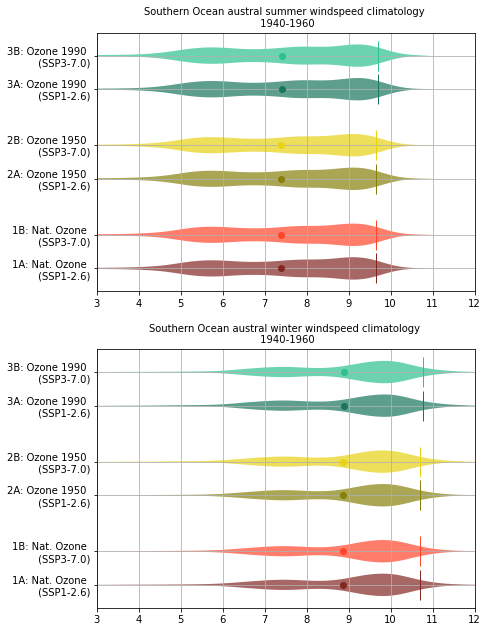

In [12]:
reload(sc)
scens = ['2B','2A','1B','1A','3B','3A']
vpstats_1950_s = [vpstats_2B_s_1950,vpstats_2A_s_1950,\
                  vpstats_1B_s_1950,vpstats_1A_s_1950,vpstats_3B_s_1950,vpstats_3A_s_1950]
p95_1950_s = [p95_2B_s_1950,p95_2A_s_1950,\
                  p95_1B_s_1950,p95_1A_s_1950,p95_3B_s_1950,p95_3A_s_1950]

scens = ['2B','2A','1B','1A','3B','3A']
vpstats_1950_w = [vpstats_2B_w_1950,vpstats_2A_w_1950,\
                  vpstats_1B_w_1950,vpstats_1A_w_1950,vpstats_3B_w_1950,vpstats_3A_w_1950]
p95_1950_w = [p95_2B_w_1950,p95_2A_w_1950,\
                  p95_1B_w_1950,p95_1A_w_1950,p95_3B_w_1950,p95_3A_w_1950]
scens = ['2B','2A','1B','1A','3B','3A']
plcs = [[5],[5.75],[3],[3.75],[1],[1.75],]

fact = 0.5
fig, axs = plt.subplots(2,1, figsize=(14*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):

    plc = plcs[i]
    vpst = vpstats_1950_s[i]
    vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    axs[0].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'])
    axs[0].plot(p95_1950_s[i],plc, marker = '|', color = sc.scen[scens[i]]['color'], markersize = 30)
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        pc.set_alpha(0.7)

    vpst = vpstats_1950_w[i]
    vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    axs[1].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'])
    axs[1].plot(p95_1950_w[i],plc, marker = '|', color = sc.scen[scens[i]]['color'], markersize = 30)
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        # pc.set_edgecolor('k')
        pc.set_alpha(0.7)

for i in range(0,2):        
    axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
    axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
                        '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
                        '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
                      fontsize = 10)
    axs[i].grid()
    axs[i].set_xlim([3,12])
    axs[i].set_xticks(np.arange(3,13,1))
    axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 10)
    axs[0].set_title('Southern Ocean austral summer windspeed climatology \n 1940-1960', fontsize = 10)
    axs[1].set_title('Southern Ocean austral winter windspeed climatology \n 1940-1960', fontsize = 10)
plt.tight_layout()

In [13]:
vpstats_1950_s = [vpstats_2B_s_1950,vpstats_2A_s_1950, vpstats_1B_s_1950,vpstats_1A_s_1950,\
           vpstats_3B_s_1950,vpstats_3A_s_1950]
p95_1950_s = [p95_2B_s_1950,p95_2A_s_1950, p95_1B_s_1950,p95_1A_s_1950,\
           p95_3B_s_1950,p95_3A_s_1950]

vpstats_1950_w = [vpstats_2B_w_1950,vpstats_2A_w_1950, vpstats_1B_w_1950,vpstats_1A_w_1950,\
           vpstats_3B_w_1950,vpstats_3A_w_1950]
p95_1950_w = [p95_2B_w_1950,p95_2A_w_1950, p95_1B_w_1950,p95_1A_w_1950,\
           p95_3B_w_1950,p95_3A_w_1950]

vpstats_2020_s = [vpstats_2B_s_2020,vpstats_2A_s_2020, vpstats_1B_s_2020,vpstats_1A_s_2020,\
           vpstats_3B_s_2020,vpstats_3A_s_2020]
p95_2020_s = [p95_2B_s_2020,p95_2A_s_2020, p95_1B_s_2020,p95_1A_s_2020,\
           p95_3B_s_2020,p95_3A_s_2020]

vpstats_2020_w = [vpstats_2B_w_2020,vpstats_2A_w_2020, vpstats_1B_w_2020,vpstats_1A_w_2020,\
           vpstats_3B_w_2020,vpstats_3A_w_2020]
p95_2020_w = [p95_2B_w_2020,p95_2A_w_2020, p95_1B_w_2020,p95_1A_w_2020,\
           p95_3B_w_2020,p95_3A_w_2020]

vpstats_2050_s = [vpstats_2B_s_2050,vpstats_2A_s_2050, vpstats_1B_s_2050,vpstats_1A_s_2050,\
           vpstats_3B_s_2050,vpstats_3A_s_2050]
p95_2050_s = [p95_2B_s_2050,p95_2A_s_2050, p95_1B_s_2050,p95_1A_s_2050,\
           p95_3B_s_2050,p95_3A_s_2050]

vpstats_2050_w = [vpstats_2B_w_2050,vpstats_2A_w_2050, vpstats_1B_w_2050,vpstats_1A_w_2050,\
           vpstats_3B_w_2050,vpstats_3A_w_2050]
p95_2050_w = [p95_2B_w_2050,p95_2A_w_2050, p95_1B_w_2050,p95_1A_w_2050,\
           p95_3B_w_2050,p95_3A_w_2050]

vpstats_2090_s = [vpstats_2B_s_2090,vpstats_2A_s_2090, vpstats_1B_s_2090,vpstats_1A_s_2090,\
           vpstats_3B_s_2090,vpstats_3A_s_2090]
p95_2090_s = [p95_2B_s_2090,p95_2A_s_2090, p95_1B_s_2090,p95_1A_s_2090,\
           p95_3B_s_2090,p95_3A_s_2090]

vpstats_2090_w = [vpstats_2B_w_2090,vpstats_2A_w_2090, vpstats_1B_w_2090,vpstats_1A_w_2090,\
           vpstats_3B_w_2090,vpstats_3A_w_2090]
p95_2090_w = [p95_2B_w_2090,p95_2A_w_2090, p95_1B_w_2090,p95_1A_w_2090,\
           p95_3B_w_2090,p95_3A_w_2090]


In [14]:
def paganini(sum_plot_f, win_plot_f, sum_p95_f, win_p95_f, tim, ghost = True):
    scens = ['2B','2A','1B','1A','3B','3A']
    plcs = [[5],[5.75],[3],[3.75],[1],[1.75],]

    fact = 0.5
    fig, axs = plt.subplots(2,1, figsize=(14*fact, 18.2*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    sum_plot = vpstats_1950_s
    win_plot = vpstats_1950_w
    sum_p95 = p95_1950_s
    win_p95 = p95_1950_w
    
    for i in range(0,6):
        ### 1950s
        if ghost:
            plc = plcs[i]
            vpst = sum_plot[i]
            vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
            axs[0].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
            axs[0].plot(p95_1950_s[i],plc, marker = '|', color = 'grey', markersize = 30)
            for pc in vplot['bodies']:
                pc.set_facecolor('grey')
                pc.set_alpha(0.65)
                pc.set_edgecolor('grey')
                

            vpst = win_plot[i]
            vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
            axs[1].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
            axs[1].plot(p95_1950_w[i],plc, marker = '|', color = 'grey', markersize = 30)
            # ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
            #        color = sc.scen[scens[i]]['color'])
            for pc in vplot['bodies']:
                pc.set_facecolor('grey')
                pc.set_alpha(0.65)
                pc.set_edgecolor('grey')
                

    ##2090s
        plc = plcs[i]
        vpst = sum_plot_f[i]
        vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[0].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
        axs[0].plot(sum_p95_f[i],plc, marker = '|', color = sc.scen[scens[i]]['color'], markersize = 30)
        for pc in vplot['bodies']:
            pc.set_facecolor(sc.scen[scens[i]]['color'])
            pc.set_edgecolor(sc.scen[scens[i]]['color'])
            pc.set_alpha(0.65)

        vpst = win_plot_f[i]
        vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[1].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
        axs[1].plot(win_p95_f[i],plc, marker = '|', color = sc.scen[scens[i]]['color'], markersize = 30)
        for pc in vplot['bodies']:
            pc.set_facecolor(sc.scen[scens[i]]['color'])
            pc.set_edgecolor(sc.scen[scens[i]]['color'])
            pc.set_alpha(0.65)

    for i in range(0,2):        
        axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
        # axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
        #                     '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
        #                     '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
        #                   fontsize = 10)
        
        # axs[i].set_yticklabels(['O$_3$ ↓, CO$_2$ ↑',
        #                     'O$_3$ ↓, CO$_2$ ↓',
        #                     'O$_3$ R, CO$_2$ ↑',
        #                     'O$_3$ R, CO$_2$ ↓ ',
        #                     'O$_3$ ↑, CO$_2$ ↑',
        #                     'O$_3$ ↑, CO$_2$ ↓'], \
        #                   fontsize = 11.5)
        axs[0].set_yticklabels(['1990 OZONE \n HIGH TEMP.',
                            '1990 OZONE \n LOW TEMP.',
                            'HIST. OZONE \n HIGH TEMP.',
                            'HIST. OZONE \n LOW TEMP.',
                            'FIXED OZONE \n HIGH TEMP.',
                            'FIXED OZONE \n LOW TEMP.'], \
                          fontsize = 11.5)
        axs[1].set_yticklabels([], \
                          fontsize = 11.5)
        axs[i].grid()
        axs[i].set_xlim([3,12])
        axs[i].set_xticks(np.arange(3,13,1))
        axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 13)
        axs[0].set_title(f'Austral Summer', fontsize = 13)
        axs[1].set_title(f'Austral Winter', fontsize = 13)
        #axs[0].set_xlabel('windspeed (m s$^{-1}$)', fontsize = 10)
        axs[1].set_xlabel('windspeed (m s$^{-1}$)', fontsize = 13)
    plt.tight_layout()
    fig.savefig(f'{pdir}/wspd_{tim}.jpg', dpi = 250)

In [15]:
def paganini_ghost(sum_plot_f, win_plot_f, sum_p95_f, win_p95_f, tim, ghost = True):
    scens = ['2B','2A','1B','1A','3B','3A']
    plcs = [[5],[5.75],[3],[3.75],[1],[1.75],]

    fact = 0.5
    fig, axs = plt.subplots(2,1, figsize=(14*fact, 18.2*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    sum_plot = vpstats_1950_s
    win_plot = vpstats_1950_w
    sum_p95 = p95_1950_s
    win_p95 = p95_1950_w
    
    for i in range(0,6):
        ### 1950s
        if ghost:
            plc = plcs[i]
            vpst = sum_plot[i]
            vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
            axs[0].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
            axs[0].plot(p95_1950_s[i],plc, marker = '|', color = 'grey', markersize = 30)
            for pc in vplot['bodies']:
                pc.set_facecolor('grey')
                pc.set_alpha(0.65)
                pc.set_edgecolor('grey')
                

            vpst = win_plot[i]
            vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
            axs[1].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
            axs[1].plot(p95_1950_w[i],plc, marker = '|', color = 'grey', markersize = 30)
            # ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
            #        color = sc.scen[scens[i]]['color'])
            for pc in vplot['bodies']:
                pc.set_facecolor('grey')
                pc.set_alpha(0.65)
                pc.set_edgecolor('grey')
                
    for i in range(0,2):        
        axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
        # axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
        #                     '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
        #                     '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
        #                   fontsize = 10)
        
        # axs[i].set_yticklabels(['O$_3$ ↓, CO$_2$ ↑',
        #                     'O$_3$ ↓, CO$_2$ ↓',
        #                     'O$_3$ R, CO$_2$ ↑',
        #                     'O$_3$ R, CO$_2$ ↓ ',
        #                     'O$_3$ ↑, CO$_2$ ↑',
        #                     'O$_3$ ↑, CO$_2$ ↓'], \
        #                   fontsize = 11.5)
        axs[0].set_yticklabels(['1990 OZONE \n HIGH TEMP.',
                            '1990 OZONE \n LOW TEMP.',
                            'HIST. OZONE \n HIGH TEMP.',
                            'HIST. OZONE \n LOW TEMP.',
                            'FIXED OZONE \n HIGH TEMP.',
                            'FIXED OZONE \n LOW TEMP.'], \
                          fontsize = 11.5)
        axs[1].set_yticklabels([], \
                          fontsize = 11.5)
        axs[i].grid()
        axs[i].set_xlim([3,12])
        axs[i].set_xticks(np.arange(3,13,1))
        axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 13)
        axs[0].set_title(f'Austral Summer', fontsize = 13)
        axs[1].set_title(f'Austral Winter', fontsize = 13)
        #axs[0].set_xlabel('windspeed (m s$^{-1}$)', fontsize = 10)
        axs[1].set_xlabel('windspeed (m s$^{-1}$)', fontsize = 13)
        
    plt.tight_layout()
    fig.savefig(f'{pdir}/wspd_ghost_{tim}.jpg', dpi = 250)

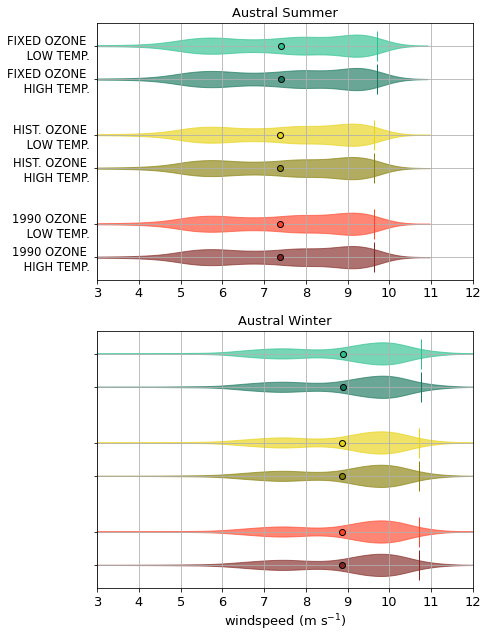

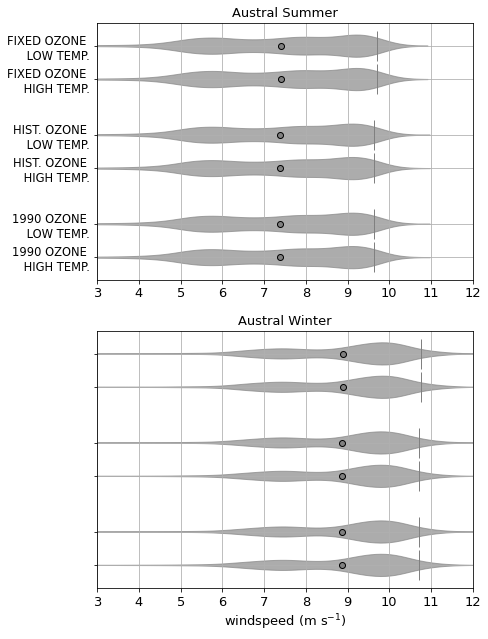

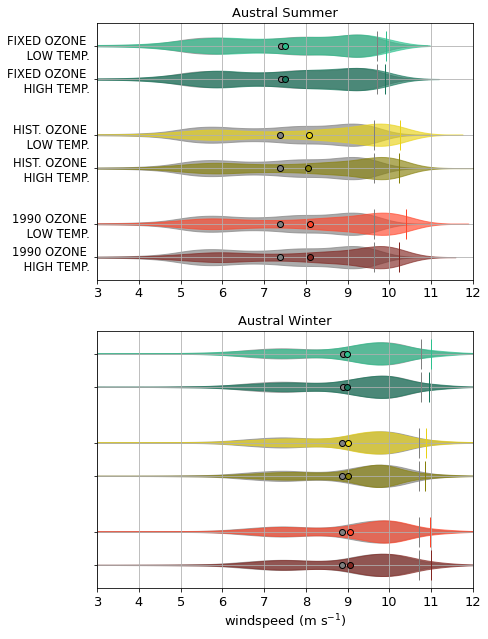

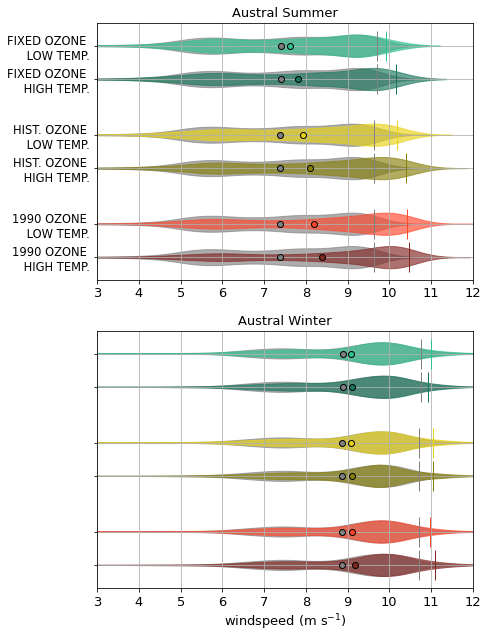

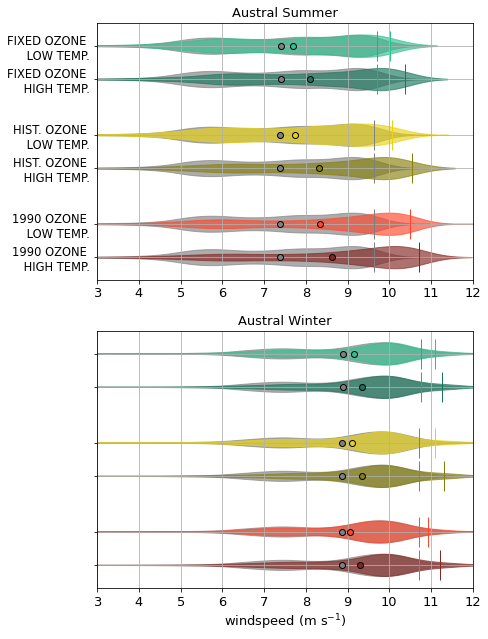

In [16]:

sum_plot_f = vpstats_1950_s
win_plot_f = vpstats_1950_w
sum_p95_f = p95_1950_s
win_p95_f = p95_1950_w
tim = '1940-1960'
paganini(sum_plot_f, win_plot_f, sum_p95_f, win_p95_f,  tim, ghost = False)
paganini_ghost(sum_plot_f, win_plot_f, sum_p95_f, win_p95_f,  tim)

sum_plot_f = vpstats_2020_s
win_plot_f = vpstats_2020_w
sum_p95_f = p95_2020_s
win_p95_f = p95_2020_w
tim = '2010-2030'
paganini(sum_plot_f, win_plot_f, sum_p95_f, win_p95_f,  tim, ghost = True)

sum_plot_f = vpstats_2050_s
win_plot_f = vpstats_2050_w
sum_p95_f = p95_2050_s
win_p95_f = p95_2050_w
tim = '2040-2060'
paganini(sum_plot_f, win_plot_f, sum_p95_f, win_p95_f,  tim, ghost = True)

sum_plot_f = vpstats_2090_s
win_plot_f = vpstats_2090_w
sum_p95_f = p95_2090_s
win_p95_f = p95_2090_w
tim = '2080-2100'
paganini(sum_plot_f, win_plot_f, sum_p95_f, win_p95_f,  tim, ghost = True)

## remake for paper

In [17]:
ts = time.time()
print(ts)
vpstats_1A_s_1950, p95_1A_s_1950 = make_vpstats('1A',12,0,20)
vpstats_1B_s_1950, p95_1B_s_1950 = make_vpstats('1B',12,0,20)
vpstats_2A_s_1950, p95_2A_s_1950 = make_vpstats('2A',12,0,20)
vpstats_2B_s_1950, p95_2B_s_1950 = make_vpstats('2B',12,0,20)
vpstats_3A_s_1950, p95_3A_s_1950 = make_vpstats('3A',12,0,20)
vpstats_3B_s_1950, p95_3B_s_1950 = make_vpstats('3B',12,0,20)

s = 1
vpstats_1A_s_1970, p95_1A_s_1970 = make_vpstats('1A',12,0+s*20,20+s*20)
vpstats_1B_s_1970, p95_1B_s_1970 = make_vpstats('1B',12,0+s*20,20+s*20)
vpstats_2A_s_1970, p95_2A_s_1970 = make_vpstats('2A',12,0+s*20,20+s*20)
vpstats_2B_s_1970, p95_2B_s_1970 = make_vpstats('2B',12,0+s*20,20+s*20)
vpstats_3A_s_1970, p95_3A_s_1970 = make_vpstats('3A',12,0+s*20,20+s*20)
vpstats_3B_s_1970, p95_3B_s_1970 = make_vpstats('3B',12,0+s*20,20+s*20)

s = 2
vpstats_1A_s_1990, p95_1A_s_1990 = make_vpstats('1A',12,0+s*20,20+s*20)
vpstats_1B_s_1990, p95_1B_s_1990 = make_vpstats('1B',12,0+s*20,20+s*20)
vpstats_2A_s_1990, p95_2A_s_1990 = make_vpstats('2A',12,0+s*20,20+s*20)
vpstats_2B_s_1990, p95_2B_s_1990 = make_vpstats('2B',12,0+s*20,20+s*20)
vpstats_3A_s_1990, p95_3A_s_1990 = make_vpstats('3A',12,0+s*20,20+s*20)
vpstats_3B_s_1990, p95_3B_s_1990 = make_vpstats('3B',12,0+s*20,20+s*20)

s = 3
vpstats_1A_s_2010, p95_1A_s_2010 = make_vpstats('1A',12,0+s*20,20+s*20)
vpstats_1B_s_2010, p95_1B_s_2010 = make_vpstats('1B',12,0+s*20,20+s*20)
vpstats_2A_s_2010, p95_2A_s_2010 = make_vpstats('2A',12,0+s*20,20+s*20)
vpstats_2B_s_2010, p95_2B_s_2010 = make_vpstats('2B',12,0+s*20,20+s*20)
vpstats_3A_s_2010, p95_3A_s_2010 = make_vpstats('3A',12,0+s*20,20+s*20)
vpstats_3B_s_2010, p95_3B_s_2010 = make_vpstats('3B',12,0+s*20,20+s*20)

s = 4
vpstats_1A_s_2030, p95_1A_s_2030 = make_vpstats('1A',12,0+s*20,20+s*20)
vpstats_1B_s_2030, p95_1B_s_2030 = make_vpstats('1B',12,0+s*20,20+s*20)
vpstats_2A_s_2030, p95_2A_s_2030 = make_vpstats('2A',12,0+s*20,20+s*20)
vpstats_2B_s_2030, p95_2B_s_2030 = make_vpstats('2B',12,0+s*20,20+s*20)
vpstats_3A_s_2030, p95_3A_s_2030 = make_vpstats('3A',12,0+s*20,20+s*20)
vpstats_3B_s_2030, p95_3B_s_2030 = make_vpstats('3B',12,0+s*20,20+s*20)

s = 5
vpstats_1A_s_2050, p95_1A_s_2050 = make_vpstats('1A',12,0+s*20,20+s*20)
vpstats_1B_s_2050, p95_1B_s_2050 = make_vpstats('1B',12,0+s*20,20+s*20)
vpstats_2A_s_2050, p95_2A_s_2050 = make_vpstats('2A',12,0+s*20,20+s*20)
vpstats_2B_s_2050, p95_2B_s_2050 = make_vpstats('2B',12,0+s*20,20+s*20)
vpstats_3A_s_2050, p95_3A_s_2050 = make_vpstats('3A',12,0+s*20,20+s*20)
vpstats_3B_s_2050, p95_3B_s_2050 = make_vpstats('3B',12,0+s*20,20+s*20)

s = 6
vpstats_1A_s_2070, p95_1A_s_2070 = make_vpstats('1A',12,0+s*20,20+s*20)
vpstats_1B_s_2070, p95_1B_s_2070 = make_vpstats('1B',12,0+s*20,20+s*20)
vpstats_2A_s_2070, p95_2A_s_2070 = make_vpstats('2A',12,0+s*20,20+s*20)
vpstats_2B_s_2070, p95_2B_s_2070 = make_vpstats('2B',12,0+s*20,20+s*20)
vpstats_3A_s_2070, p95_3A_s_2070 = make_vpstats('3A',12,0+s*20,20+s*20)
vpstats_3B_s_2070, p95_3B_s_2070 = make_vpstats('3B',12,0+s*20,20+s*20)

s = 7
vpstats_1A_s_2090, p95_1A_s_2090 = make_vpstats('1A',12,0+s*20,20+s*20)
vpstats_1B_s_2090, p95_1B_s_2090 = make_vpstats('1B',12,0+s*20,20+s*20)
vpstats_2A_s_2090, p95_2A_s_2090 = make_vpstats('2A',12,0+s*20,20+s*20)
vpstats_2B_s_2090, p95_2B_s_2090 = make_vpstats('2B',12,0+s*20,20+s*20)
vpstats_3A_s_2090, p95_3A_s_2090 = make_vpstats('3A',12,0+s*20,20+s*20)
vpstats_3B_s_2090, p95_3B_s_2090 = make_vpstats('3B',12,0+s*20,20+s*20)


1673238947.090871


In [18]:
ts = time.time()
print(ts)
vpstats_1A_w_1950, p95_1A_w_1950 = make_vpstats('1A',13,0,20)
vpstats_1B_w_1950, p95_1B_w_1950 = make_vpstats('1B',13,0,20)
vpstats_2A_w_1950, p95_2A_w_1950 = make_vpstats('2A',13,0,20)
vpstats_2B_w_1950, p95_2B_w_1950 = make_vpstats('2B',13,0,20)
vpstats_3A_w_1950, p95_3A_w_1950 = make_vpstats('3A',13,0,20)
vpstats_3B_w_1950, p95_3B_w_1950 = make_vpstats('3B',13,0,20)

s = 1
vpstats_1A_w_1970, p95_1A_w_1970 = make_vpstats('1A',13,0+s*20,20+s*20)
vpstats_1B_w_1970, p95_1B_w_1970 = make_vpstats('1B',13,0+s*20,20+s*20)
vpstats_2A_w_1970, p95_2A_w_1970 = make_vpstats('2A',13,0+s*20,20+s*20)
vpstats_2B_w_1970, p95_2B_w_1970 = make_vpstats('2B',13,0+s*20,20+s*20)
vpstats_3A_w_1970, p95_3A_w_1970 = make_vpstats('3A',13,0+s*20,20+s*20)
vpstats_3B_w_1970, p95_3B_w_1970 = make_vpstats('3B',13,0+s*20,20+s*20)

s = 2
vpstats_1A_w_1990, p95_1A_w_1990 = make_vpstats('1A',13,0+s*20,20+s*20)
vpstats_1B_w_1990, p95_1B_w_1990 = make_vpstats('1B',13,0+s*20,20+s*20)
vpstats_2A_w_1990, p95_2A_w_1990 = make_vpstats('2A',13,0+s*20,20+s*20)
vpstats_2B_w_1990, p95_2B_w_1990 = make_vpstats('2B',13,0+s*20,20+s*20)
vpstats_3A_w_1990, p95_3A_w_1990 = make_vpstats('3A',13,0+s*20,20+s*20)
vpstats_3B_w_1990, p95_3B_w_1990 = make_vpstats('3B',13,0+s*20,20+s*20)

s = 3
vpstats_1A_w_2010, p95_1A_w_2010 = make_vpstats('1A',13,0+s*20,20+s*20)
vpstats_1B_w_2010, p95_1B_w_2010 = make_vpstats('1B',13,0+s*20,20+s*20)
vpstats_2A_w_2010, p95_2A_w_2010 = make_vpstats('2A',13,0+s*20,20+s*20)
vpstats_2B_w_2010, p95_2B_w_2010 = make_vpstats('2B',13,0+s*20,20+s*20)
vpstats_3A_w_2010, p95_3A_w_2010 = make_vpstats('3A',13,0+s*20,20+s*20)
vpstats_3B_w_2010, p95_3B_w_2010 = make_vpstats('3B',13,0+s*20,20+s*20)

s = 4
vpstats_1A_w_2030, p95_1A_w_2030 = make_vpstats('1A',13,0+s*20,20+s*20)
vpstats_1B_w_2030, p95_1B_w_2030 = make_vpstats('1B',13,0+s*20,20+s*20)
vpstats_2A_w_2030, p95_2A_w_2030 = make_vpstats('2A',13,0+s*20,20+s*20)
vpstats_2B_w_2030, p95_2B_w_2030 = make_vpstats('2B',13,0+s*20,20+s*20)
vpstats_3A_w_2030, p95_3A_w_2030 = make_vpstats('3A',13,0+s*20,20+s*20)
vpstats_3B_w_2030, p95_3B_w_2030 = make_vpstats('3B',13,0+s*20,20+s*20)

s = 5
vpstats_1A_w_2050, p95_1A_w_2050 = make_vpstats('1A',13,0+s*20,20+s*20)
vpstats_1B_w_2050, p95_1B_w_2050 = make_vpstats('1B',13,0+s*20,20+s*20)
vpstats_2A_w_2050, p95_2A_w_2050 = make_vpstats('2A',13,0+s*20,20+s*20)
vpstats_2B_w_2050, p95_2B_w_2050 = make_vpstats('2B',13,0+s*20,20+s*20)
vpstats_3A_w_2050, p95_3A_w_2050 = make_vpstats('3A',13,0+s*20,20+s*20)
vpstats_3B_w_2050, p95_3B_w_2050 = make_vpstats('3B',13,0+s*20,20+s*20)

s = 6
vpstats_1A_w_2070, p95_1A_w_2070 = make_vpstats('1A',13,0+s*20,20+s*20)
vpstats_1B_w_2070, p95_1B_w_2070 = make_vpstats('1B',13,0+s*20,20+s*20)
vpstats_2A_w_2070, p95_2A_w_2070 = make_vpstats('2A',13,0+s*20,20+s*20)
vpstats_2B_w_2070, p95_2B_w_2070 = make_vpstats('2B',13,0+s*20,20+s*20)
vpstats_3A_w_2070, p95_3A_w_2070 = make_vpstats('3A',13,0+s*20,20+s*20)
vpstats_3B_w_2070, p95_3B_w_2070 = make_vpstats('3B',13,0+s*20,20+s*20)

s = 7
vpstats_1A_w_2090, p95_1A_w_2090 = make_vpstats('1A',13,0+s*20,20+s*20)
vpstats_1B_w_2090, p95_1B_w_2090 = make_vpstats('1B',13,0+s*20,20+s*20)
vpstats_2A_w_2090, p95_2A_w_2090 = make_vpstats('2A',13,0+s*20,20+s*20)
vpstats_2B_w_2090, p95_2B_w_2090 = make_vpstats('2B',13,0+s*20,20+s*20)
vpstats_3A_w_2090, p95_3A_w_2090 = make_vpstats('3A',13,0+s*20,20+s*20)
vpstats_3B_w_2090, p95_3B_w_2090 = make_vpstats('3B',13,0+s*20,20+s*20)

te = time.time()
print(te-ts)

1673238990.94129
43.052937269210815


In [19]:
vpstats_1950_s = [vpstats_2B_s_1950,vpstats_2A_s_1950, vpstats_1B_s_1950,vpstats_1A_s_1950,\
           vpstats_3B_s_1950,vpstats_3A_s_1950]
p95_1950_s = [p95_2B_s_1950,p95_2A_s_1950, p95_1B_s_1950,p95_1A_s_1950,\
           p95_3B_s_1950,p95_3A_s_1950]

vpstats_1970_s = [vpstats_2B_s_1970,vpstats_2A_s_1970, vpstats_1B_s_1970,vpstats_1A_s_1970,\
           vpstats_3B_s_1970,vpstats_3A_s_1970]
p95_1970_s = [p95_2B_s_1970,p95_2A_s_1970, p95_1B_s_1970,p95_1A_s_1970,\
           p95_3B_s_1970,p95_3A_s_1970]

vpstats_1990_s = [vpstats_2B_s_1990,vpstats_2A_s_1990, vpstats_1B_s_1990,vpstats_1A_s_1990,\
           vpstats_3B_s_1990,vpstats_3A_s_1990]
p95_1990_s = [p95_2B_s_1990,p95_2A_s_1990, p95_1B_s_1990,p95_1A_s_1990,\
           p95_3B_s_1990,p95_3A_s_1990]

vpstats_2010_s = [vpstats_2B_s_2010,vpstats_2A_s_2010, vpstats_1B_s_2010,vpstats_1A_s_2010,\
           vpstats_3B_s_2010,vpstats_3A_s_2010]
p95_2010_s = [p95_2B_s_2010,p95_2A_s_2010, p95_1B_s_2010,p95_1A_s_2010,\
           p95_3B_s_2010,p95_3A_s_2010]

vpstats_2030_s = [vpstats_2B_s_2030,vpstats_2A_s_2030, vpstats_1B_s_2030,vpstats_1A_s_2030,\
           vpstats_3B_s_2030,vpstats_3A_s_2030]
p95_2030_s = [p95_2B_s_2030,p95_2A_s_2030, p95_1B_s_2030,p95_1A_s_2030,\
           p95_3B_s_2030,p95_3A_s_2030]

vpstats_2050_s = [vpstats_2B_s_2050,vpstats_2A_s_2050, vpstats_1B_s_2050,vpstats_1A_s_2050,\
           vpstats_3B_s_2050,vpstats_3A_s_2050]
p95_2050_s = [p95_2B_s_2050,p95_2A_s_2050, p95_1B_s_2050,p95_1A_s_2050,\
           p95_3B_s_2050,p95_3A_s_2050]

vpstats_2070_s = [vpstats_2B_s_2070,vpstats_2A_s_2070, vpstats_1B_s_2070,vpstats_1A_s_2070,\
           vpstats_3B_s_2070,vpstats_3A_s_2070]
p95_2070_s = [p95_2B_s_2070,p95_2A_s_2070, p95_1B_s_2070,p95_1A_s_2070,\
           p95_3B_s_2070,p95_3A_s_2070]

vpstats_2090_s = [vpstats_2B_s_2090,vpstats_2A_s_2090, vpstats_1B_s_2090,vpstats_1A_s_2090,\
           vpstats_3B_s_2090,vpstats_3A_s_2090]
p95_2090_s = [p95_2B_s_2090,p95_2A_s_2090, p95_1B_s_2090,p95_1A_s_2090,\
           p95_3B_s_2090,p95_3A_s_2090]


vpstats_s = [vpstats_1950_s, vpstats_1970_s, vpstats_1990_s, vpstats_2010_s,\
             vpstats_2030_s, vpstats_2050_s, vpstats_2070_s, vpstats_2090_s]
p95_s = [p95_1950_s, p95_1970_s, p95_1990_s, p95_2010_s,\
             p95_2030_s, p95_2050_s, p95_2070_s, p95_2090_s]

In [20]:
vpstats_1950_w = [vpstats_2B_w_1950,vpstats_2A_w_1950, vpstats_1B_w_1950,vpstats_1A_w_1950,\
           vpstats_3B_w_1950,vpstats_3A_w_1950]
p95_1950_w = [p95_2B_w_1950,p95_2A_w_1950, p95_1B_w_1950,p95_1A_w_1950,\
           p95_3B_w_1950,p95_3A_w_1950]

vpstats_1970_w = [vpstats_2B_w_1970,vpstats_2A_w_1970, vpstats_1B_w_1970,vpstats_1A_w_1970,\
           vpstats_3B_w_1970,vpstats_3A_w_1970]
p95_1970_w = [p95_2B_w_1970,p95_2A_w_1970, p95_1B_w_1970,p95_1A_w_1970,\
           p95_3B_w_1970,p95_3A_w_1970]

vpstats_1990_w = [vpstats_2B_w_1990,vpstats_2A_w_1990, vpstats_1B_w_1990,vpstats_1A_w_1990,\
           vpstats_3B_w_1990,vpstats_3A_w_1990]
p95_1990_w = [p95_2B_w_1990,p95_2A_w_1990, p95_1B_w_1990,p95_1A_w_1990,\
           p95_3B_w_1990,p95_3A_w_1990]

vpstats_2010_w = [vpstats_2B_w_2010,vpstats_2A_w_2010, vpstats_1B_w_2010,vpstats_1A_w_2010,\
           vpstats_3B_w_2010,vpstats_3A_w_2010]
p95_2010_w = [p95_2B_w_2010,p95_2A_w_2010, p95_1B_w_2010,p95_1A_w_2010,\
           p95_3B_w_2010,p95_3A_w_2010]

vpstats_2030_w = [vpstats_2B_w_2030,vpstats_2A_w_2030, vpstats_1B_w_2030,vpstats_1A_w_2030,\
           vpstats_3B_w_2030,vpstats_3A_w_2030]
p95_2030_w = [p95_2B_w_2030,p95_2A_w_2030, p95_1B_w_2030,p95_1A_w_2030,\
           p95_3B_w_2030,p95_3A_w_2030]

vpstats_2050_w = [vpstats_2B_w_2050,vpstats_2A_w_2050, vpstats_1B_w_2050,vpstats_1A_w_2050,\
           vpstats_3B_w_2050,vpstats_3A_w_2050]
p95_2050_w = [p95_2B_w_2050,p95_2A_w_2050, p95_1B_w_2050,p95_1A_w_2050,\
           p95_3B_w_2050,p95_3A_w_2050]

vpstats_2070_w = [vpstats_2B_w_2070,vpstats_2A_w_2070, vpstats_1B_w_2070,vpstats_1A_w_2070,\
           vpstats_3B_w_2070,vpstats_3A_w_2070]
p95_2070_w = [p95_2B_w_2070,p95_2A_w_2070, p95_1B_w_2070,p95_1A_w_2070,\
           p95_3B_w_2070,p95_3A_w_2070]

vpstats_2090_w = [vpstats_2B_w_2090,vpstats_2A_w_2090, vpstats_1B_w_2090,vpstats_1A_w_2090,\
           vpstats_3B_w_2090,vpstats_3A_w_2090]
p95_2090_w = [p95_2B_w_2090,p95_2A_w_2090, p95_1B_w_2090,p95_1A_w_2090,\
           p95_3B_w_2090,p95_3A_w_2090]


vpstats_w = [vpstats_1950_w, vpstats_1970_w, vpstats_1990_w, vpstats_2010_w,\
             vpstats_2030_w, vpstats_2050_w, vpstats_2070_w, vpstats_2090_w]
p95_w = [p95_1950_w, p95_1970_w, p95_1990_w, p95_2010_w,\
             p95_2030_w, p95_2050_w, p95_2070_w, p95_2090_w]

In [21]:
def paganini_prog(sum_plot_f, sum_p95_f, tcol, axind, lab = False, tlab = ''):
    scens = ['2B','2A','1B','1A','3B','3A']
    plcs = [[5],[5.75],[3],[3.75],[1],[1.75],]
    
    for i in range(0,6):
        plc = plcs[i]
        vpst = sum_plot_f[i]

        if lab & (i ==1) :
            # print(plc)
            # print(vpst)
            vplot = axs[axind].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
            axs[axind].plot([17,18],[2,3], linestyle = '-', color = tcol, label = tlab)
        else:
            vplot = axs[axind].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
        axs[axind].plot((vpst[0]['mean']),plc, marker = 'o', color = tcol, markeredgecolor = 'k')
        axs[axind].plot(sum_p95_f[i],plc, marker = '|', color = tcol, markersize = 30)
        for pc in vplot['bodies']:
            pc.set_facecolor('None')
            pc.set_edgecolor(tcol)
            pc.set_alpha(1)

    plt.tight_layout()
    # fig.savefig(f'{pdir}/wspd_{tim}.jpg', dpi = 250)

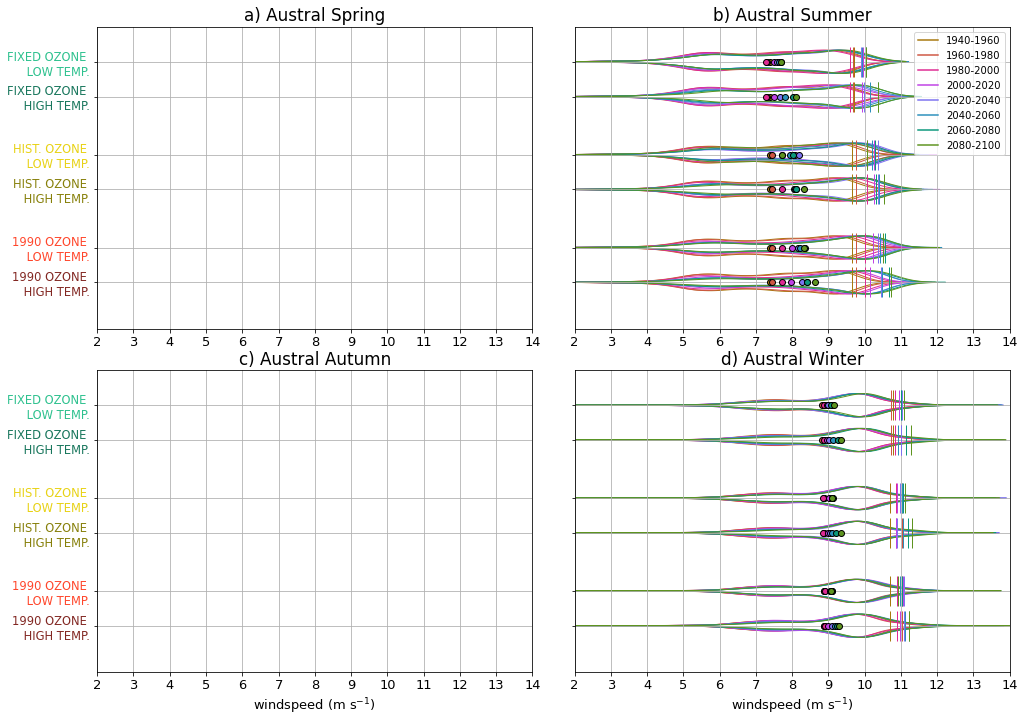

In [22]:
fact = 0.5
fig, axs = plt.subplots(2,2, figsize=(27*fact, 19.5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
tcm = cm.cm.phase

vpstats_s = [vpstats_1950_s, vpstats_1970_s, vpstats_1990_s, vpstats_2010_s,\
             vpstats_2030_s, vpstats_2050_s, vpstats_2070_s, vpstats_2090_s]
p95_s = [p95_1950_s, p95_1970_s, p95_1990_s, p95_2010_s,\
             p95_2030_s, p95_2050_s, p95_2070_s, p95_2090_s]

vpstats_w = [vpstats_1950_w, vpstats_1970_w, vpstats_1990_w, vpstats_2010_w,\
             vpstats_2030_w, vpstats_2050_w, vpstats_2070_w, vpstats_2090_w]
p95_w = [p95_1950_w, p95_1970_w, p95_1990_w, p95_2010_w,\
             p95_2030_w, p95_2050_w, p95_2070_w, p95_2090_w]
labs = ['1940-1960','1960-1980','1980-2000','2000-2020','2020-2040','2040-2060','2060-2080','2080-2100']
for i in range(0,8):
    tcol = tcm(1.*(i)/8)
    sum_plot_f = vpstats_s[i]; sum_p95_f = p95_s[i]
    
    paganini_prog(sum_plot_f, sum_p95_f, tcol, 1, lab = True, tlab = labs[i])
    sum_plot_f = vpstats_w[i]; sum_p95_f = p95_w[i]
    paganini_prog(sum_plot_f, sum_p95_f, tcol, 3)
    
tits = ['a) Austral Spring', 'b) Austral Summer', 'c) Austral Autumn', 'd) Austral Winter']
axl = ['a)', 'b)', 'c)', 'd)']
for axind in range(0,4):            
    axs[axind].set_yticks([1,1.75,3,3.75,5,5.75])
    if (axind == 0) | (axind == 2):
        axs[axind].set_yticklabels(['1990 OZONE \n HIGH TEMP.',
                            '1990 OZONE \n LOW TEMP.',
                            'HIST. OZONE \n HIGH TEMP.',
                            'HIST. OZONE \n LOW TEMP.',
                            'FIXED OZONE \n HIGH TEMP.',
                            'FIXED OZONE \n LOW TEMP.'], \
                          fontsize = 11.5)

        for t in axs[axind].get_yticklabels():
            txt = t.get_text()
            if '1990 OZONE \n LOW TEMP.' in txt:
                t.set_color(sc.scen['3A']['color'])
            if '1990 OZONE \n HIGH TEMP.' in txt:
                t.set_color(sc.scen['3B']['color'])
            if 'HIST. OZONE \n LOW TEMP.' in txt:
                t.set_color(sc.scen['1A']['color'])
            if 'HIST. OZONE \n HIGH TEMP.' in txt:
                t.set_color(sc.scen['1B']['color'])
            if 'FIXED OZONE \n LOW TEMP.' in txt:
                t.set_color(sc.scen['2A']['color'])
            if 'FIXED OZONE \n HIGH TEMP.' in txt:
                t.set_color(sc.scen['2B']['color'])
                
    else:
        axs[axind].set_yticklabels([], \
                          fontsize = 11.5)
    axs[1].legend(bbox_to_anchor = [1.0, 1], fontsize = 10)
    axs[axind].grid()
    axs[axind].set_xlim([2,14])
    axs[axind].set_ylim([0,6.5])
    axs[axind].set_xticks(np.arange(2,15,1))
    axs[axind].set_xticklabels(np.arange(2,15,1), fontsize = 13)
    axs[3].set_xlabel('windspeed (m s$^{-1}$)', fontsize = 13)
    axs[2].set_xlabel('windspeed (m s$^{-1}$)', fontsize = 13)
    #axs[axind].text(2.2,0.5, axl[axind])
    axs[axind].set_title(tits[axind])

Text(0.5, 1.0, 'area-averaged windspeed south of -50S, austral summer')

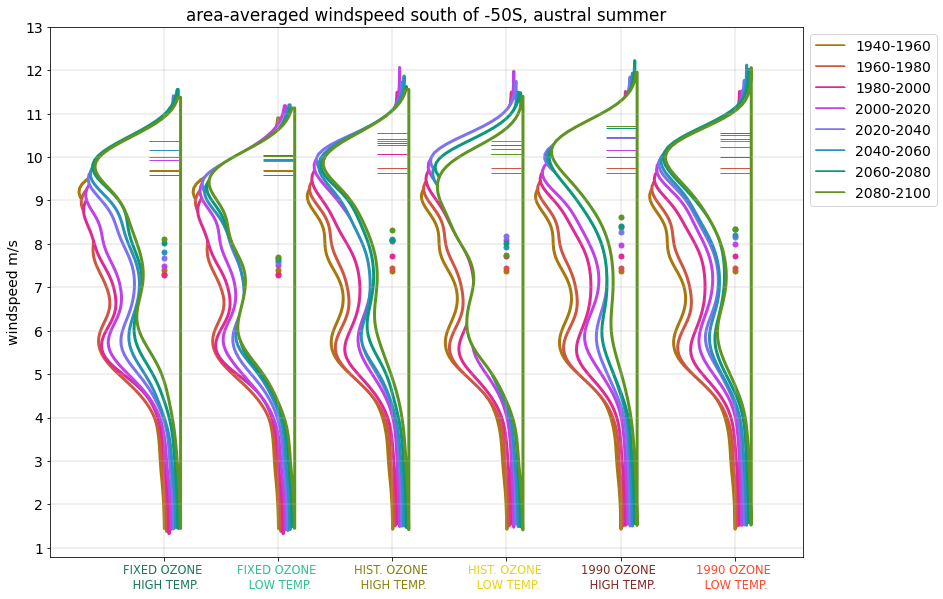

In [23]:
vpstats_s = [vpstats_1950_s, vpstats_1970_s, vpstats_1990_s, vpstats_2010_s,\
             vpstats_2030_s, vpstats_2050_s, vpstats_2070_s, vpstats_2090_s]
p95_s = [p95_1950_s, p95_1970_s, p95_1990_s, p95_2010_s,\
             p95_2030_s, p95_2050_s, p95_2070_s, p95_2090_s]
fig, ax = plt.subplots(1,1, figsize=(27*fact, 19.5*fact), facecolor='w', edgecolor='k')
tcm = cm.cm.phase
for k in range(0,6):
    for i in range(0,8):
        tind = 1.5+(k*0.5)+i*.01
        plc = [tind]
        tcol = tcm(1.*(i)/8)
        fact = 0.4
        plc = [tind]
        vpst = vpstats_s[i][k]
        sum_p95_f = p95_s[i][k]
        #print(vpst)
        vplot = ax.violin(vpst, plc, vert=True, widths = 0.75, showmeans=False, showextrema=False,
                          showmedians=False)
        for b in vplot['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
            b.set_facecolor('w')
            b.set_alpha(1)
            b.set_edgecolor(tcol)
            b.set_linewidth(3)
            
for k in range(0,6):
    for i in range(0,8):
        labs = ['1940-1960','1960-1980','1980-2000','2000-2020',\
                '2020-2040','2040-2060','2060-2080','2080-2100']

        tind = 1.5+(k*0.5)
        tcol = tcm(1.*(i)/8)
        plc = [tind]
        vpst = vpstats_s[i][k]
        sum_p95_f = p95_s[i][k]
        ax.plot(plc, vpst[0]['mean'], marker = '.', \
                color = tcol, markersize = 10)
        if k == 0:
            ax.plot(plc, sum_p95_f, marker = '_', color = tcol, markersize = 30,
                   label = labs[i])
        else:
            ax.plot(plc, sum_p95_f, marker = '_', color = tcol, markersize = 30)
ax.set_xticks([1.5,2,2.5,3,3.5,4])

ax.set_xticklabels(['FIXED OZONE \n HIGH TEMP.',
                'FIXED OZONE \n LOW TEMP.',
                'HIST. OZONE \n HIGH TEMP.',
                'HIST. OZONE \n LOW TEMP.',
                '1990 OZONE \n HIGH TEMP.',
                '1990 OZONE \n LOW TEMP.'],
              fontsize = 11.5)

for t in ax.get_xticklabels():
    txt = t.get_text()
    if '1990 OZONE \n LOW TEMP.' in txt:
        t.set_color(sc.scen['3A']['color'])
    if '1990 OZONE \n HIGH TEMP.' in txt:
        t.set_color(sc.scen['3B']['color'])
    if 'HIST. OZONE \n LOW TEMP.' in txt:
        t.set_color(sc.scen['1A']['color'])
    if 'HIST. OZONE \n HIGH TEMP.' in txt:
        t.set_color(sc.scen['1B']['color'])
    if 'FIXED OZONE \n LOW TEMP.' in txt:
        t.set_color(sc.scen['2A']['color'])
    if 'FIXED OZONE \n HIGH TEMP.' in txt:
        t.set_color(sc.scen['2B']['color'])
        
ax.set_yticks(np.arange(1,14,1))
ax.set_xlim([1,4.3])
ax.grid(linewidth = 0.4)
ax.legend(bbox_to_anchor = [1,1])
ax.set_ylabel('windspeed m/s')
ax.set_title('area-averaged windspeed south of -50S, austral summer')

In [24]:
sc.scen['2B']

{'hist_dir': 'hist/u-cj198_hist_1950start1950ozone/',
 'fut_dir': 'ssp370/u-cj881_ssp370_1950start1950ozone/',
 'name': 'FIXED OZONE \n HIGH TEMP.',
 'name2': '2B: Ozone1950-SSP370',
 'color': '#18765C',
 'color2': 'green'}

In [25]:
# ghost = True
# sum_plot_f = vpstats_2090_s
# win_plot_f = vpstats_2090_w
# tim = '2080-2100'
# scens = ['1A','1B','2A','2B','3A','3B']
# plcs = [[1],[1.75],[3],[3.75],[5],[5.75]]

# fact = 0.5
# fig, axs = plt.subplots(2,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# sum_plot = vpstats_1950_s
# win_plot = vpstats_1950_w

# for i in range(0,6):
#     ### 1950s
#     if ghost:
#         plc = plcs[i]
#         vpst = sum_plot[i]
#         vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
#                           showmedians=False)
#         axs[0].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
#         for pc in vplot['bodies']:
#             pc.set_facecolor('grey')
#             pc.set_alpha(0.5)
#             pc.set_edgecolor('grey')


#         vpst = win_plot[i]
#         vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
#                           showmedians=False)
#         axs[1].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')

#         # ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
#         #        color = sc.scen[scens[i]]['color'])
#         for pc in vplot['bodies']:
#             pc.set_facecolor('grey')
#             pc.set_alpha(0.5)
#             pc.set_edgecolor('grey')


# ##2090s
#     plc = plcs[i]
#     vpst = sum_plot_f[i]
#     vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
#                       showmedians=False)
#     axs[0].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
#     for pc in vplot['bodies']:
#         pc.set_facecolor(sc.scen[scens[i]]['color'])
#         pc.set_edgecolor(sc.scen[scens[i]]['color'])
#         pc.set_alpha(0.5)

#     vpst = win_plot_f[i]
#     vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
#                       showmedians=False)
#     axs[1].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
#     for pc in vplot['bodies']:
#         pc.set_facecolor(sc.scen[scens[i]]['color'])
#         pc.set_edgecolor(sc.scen[scens[i]]['color'])
#         pc.set_alpha(0.5)

# for i in range(0,2):        
#     axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
#     axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
#                         '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
#                         '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
#                       fontsize = 10)
#     axs[i].grid()
#     axs[i].set_xlim([3,12])
#     axs[i].set_xticks(np.arange(3,13,1))
#     axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 10)
#     axs[0].set_title(f'Austral Summer Wind Speed Distribution (2080-2100)', fontsize = 12)
#     axs[1].set_title(f'Austral Winter Wind Speed Distribution (2080-2100)', fontsize = 12)
#     axs[0].set_xlabel('m s$^{-1}$', fontsize = 10)
#     axs[1].set_xlabel('m s$^{-1}$', fontsize = 10)
# plt.tight_layout()
# fig.savefig(f'{pdir}/wspd_annot_{tim}.jpg', dpi = 250)

# get preindustrial wind speed 

In [26]:
def get_means(scen):
    tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    test_csize = tmesh.csize[0:37,:].values
    tweights = np.ravel(test_csize)
    q = xr.open_dataset(tw)
    tscen = np.zeros([2,161])
    for i in range(0,161):
        test_wspd = (q.mean_wspd[i,12,0:37,:].values)
        data = np.ravel(test_wspd)

        mean, sumw = np.ma.average(data, weights=list(tweights), returned=True)
        tscen[0,i] = mean
        test_wspd = (q.mean_wspd[i,13,0:37,:].values)
        data = np.ravel(test_wspd)
        mean, sumw = np.ma.average(data, weights=list(tweights), returned=True)
        tscen[1,i] = mean

    return tscen

In [27]:
def get_means_PI(scen):
    tw = f'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/PI_scen_I_have_lost_it.nc'
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    test_csize = tmesh.csize[0:37,:].values
    tweights = np.ravel(test_csize)
    q = xr.open_dataset(tw)
    tscen = np.zeros([2,80])
    for i in range(0,80):
        test_wspd = (q.mean_wspd[i,12,0:37,:].values)
        data = np.ravel(test_wspd)

        mean, sumw = np.ma.average(data, weights=list(tweights), returned=True)
        tscen[0,i] = mean
        test_wspd = (q.mean_wspd[i,13,0:37,:].values)
        data = np.ravel(test_wspd)
        mean, sumw = np.ma.average(data, weights=list(tweights), returned=True)
        tscen[1,i] = mean

    return tscen

<xarray.Dataset>
Dimensions:    (mon: 15, x: 182, y: 149, yr: 80)
Coordinates:
  * yr         (yr) int64 2220 2221 2222 2223 2224 ... 2295 2296 2297 2298 2299
  * mon        (mon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 174 175 176 177 178 179 180 181
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 141 142 143 144 145 146 147 148
Data variables:
    mean_wspd  (yr, mon, y, x) float64 ...
Attributes:
    desc:     mean monthly maps of wspd, made from ~/scratch/MET_forcing/
    desc2:    summer is month 13, winter is month 14, full year is month 15 (...


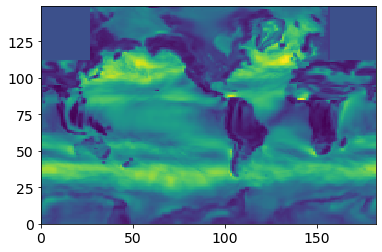

In [28]:
w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_PI_monthly_wspd.nc')
print(w)
plt.pcolormesh(w['mean_wspd'][0,0,:,:])

w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/PI_scen_I_have_lost_it.nc')


plt.pcolormesh(w['mean_wspd'][0,0,:,:])

In [29]:
ar_PI = get_means_PI('PI')

In [30]:
ar_1A = get_means('1A')
ar_1B = get_means('1B')
ar_2A = get_means('2A')
ar_2B = get_means('2B')
ar_3A = get_means('3A')
ar_3B = get_means('3B')
ar_3B = get_means('3B')

In [31]:

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


ar_1A_mv = moving_average(ar_1A[0,:],10)

np.shape(ar_1A_mv)

ar_PI_mv_summer = moving_average(ar_PI[0,:],10)
ar_PI_mv_winter = moving_average(ar_PI[1,:],10)

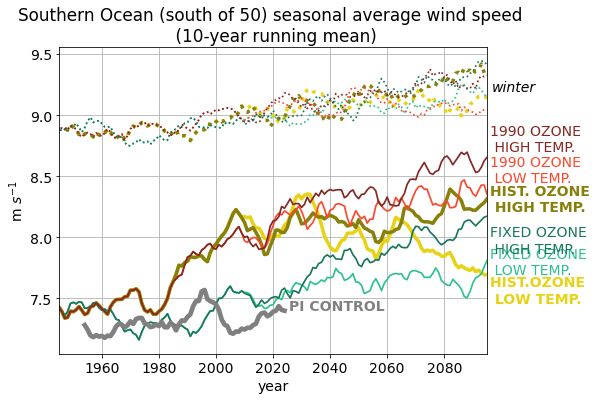

In [32]:
reload(sc)
scens = ['1A','1B','2A','2B','3A','3B']
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
## rude patch
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
ar_1A[:,30]=ar_1A[:,29];
ar_1B[:,30]=ar_1B[:,29];
ar_2A[:,41]=ar_2A[:,40];
ar_2B[:,41]=ar_2B[:,40];
ar_2B[:,142]=ar_2B[:,141];
ar_3A[:,30]=ar_3A[:,29];
ar_3B[:,30]=ar_3B[:,29];

labs_s = ['1A: NatlOzone-SSP126 (winter)', '1B: NatlOzone-SSP370', '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370']
labs_w = ['1A: NatlOzone-SSP126 (winter)', '1B: NatlOzone-SSP370', '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370']

#

tf = [0.23,0.1,0.11,0.3,-0.1,-0.05]

fact = 0.7
fig, axs = plt.subplots(1,1, figsize=(13*fact, 9*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()
for i in range(0,6):
    if i <2:
        lw = 3.5
    else:
        lw = 1.7
    
    if i < 2:
        
        tplt = scen_ars[i][0,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam} (summer)'
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = '-',\
                label = tlab)
        axs.text(2096,moving_average(tplt,10)[151]-tf[i], sc.scen[scens[i]]['name'],\
                 color = sc.scen[scens[i]]['color'],  fontweight = 'bold')
        tplt = scen_ars[i][1,:]
        tnam = sc.scen[scens[i]]['name']
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = ':',\
                label = f'{tnam} (winter)')
    else:
        tplt = scen_ars[i][0,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam}'
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = '-',\
                label = tlab)
        axs.text(2096,moving_average(tplt,10)[151]-tf[i], sc.scen[scens[i]]['name'],\
                 color = sc.scen[scens[i]]['color'])
        
        tplt = scen_ars[i][1,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam}'
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = ':',\
               )

axs.plot(np.arange(1954,1954+71), ar_PI_mv_summer, color = 'grey', linewidth = lw+3, linestyle = '-')
axs.text(2025.5,7.4, 'PI CONTROL', fontweight = 'bold',\
             color = 'grey')
axs.text(2096.5,9.2, 'winter', fontstyle = 'italic',\
             color = 'k')

    # axs.legend(ncol = 1, bbox_to_anchor = [0.75,-0.15], fontsize = 13)

axs.grid()
axs.set_xlim(1945,2095)
axs.set_ylabel('m $s^{-1}$')
axs.set_xlabel('year')
axs.set_title('Southern Ocean (south of 50) seasonal average wind speed \n (10-year running mean)')
fig.tight_layout(pad=2.4)
# pdir = '/gpfs/home/mep22dku/scratch/SOZONE/PICTURES/OVERVIEW/'
# fig.savefig(f'{pdir}/wspd_10yrmean.jpg', dpi = 250)

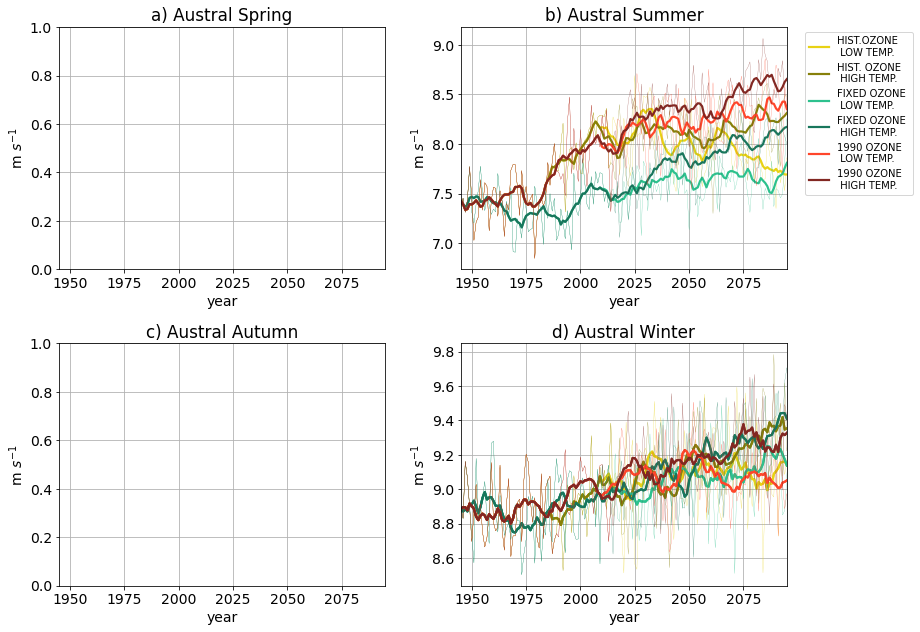

In [33]:
reload(sc)
scens = ['1A','1B','2A','2B','3A','3B']
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
## rude patch
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
ar_1A[:,30]=ar_1A[:,29];
ar_1B[:,30]=ar_1B[:,29];
ar_2A[:,41]=ar_2A[:,40];
ar_2B[:,41]=ar_2B[:,40];
ar_2B[:,142]=ar_2B[:,141];
ar_3A[:,30]=ar_3A[:,29];
ar_3B[:,30]=ar_3B[:,29];

labs_s = ['1A: NatlOzone-SSP126 (winter)', '1B: NatlOzone-SSP370', '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370']
labs_w = ['1A: NatlOzone-SSP126 (winter)', '1B: NatlOzone-SSP370', '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370']

#

tf = [0.23,0.1,0.11,0.3,-0.1,-0.05]

fact = 1.0
fig, axs = plt.subplots(2,2, figsize=(13*fact, 9*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

lw = 2.2
for i in range(0,6):

        tplt = scen_ars[i][0,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam}'
        axs[1].plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = '-',\
                label = sc.scen[scens[i]]['name'])
        axs[1].plot(np.arange(1940,2101,1),tplt,\
                 color = sc.scen[scens[i]]['color'], linewidth = 0.2, linestyle = '-')
        # axs[1].text(2096,moving_average(tplt,10)[151]-tf[i], sc.scen[scens[i]]['name'],\
        #          color = sc.scen[scens[i]]['color'])
        axs[1].legend(bbox_to_anchor = [1.04, 1], fontsize = 10)
        
        tplt = scen_ars[i][1,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam}'
        axs[3].plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = '-',)
        axs[3].plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = '-',\
                label = f'{tnam} (winter)')
        axs[3].plot(np.arange(1940,2101,1),tplt,\
                 color = sc.scen[scens[i]]['color'], linewidth = 0.2, linestyle = '-')


    # axs.legend(ncol = 1, bbox_to_anchor = [0.75,-0.15], fontsize = 13)
tits = ['a) Austral Spring', 'b) Austral Summer', 'c) Austral Autumn', 'd) Austral Winter']

for i in range(0,4):
    axs[i].grid()
    axs[i].set_xlim(1945,2095)
    axs[i].set_ylabel('m $s^{-1}$')
    axs[i].set_xlabel('year')
    axs[i].set_title(tits[i])
    # axs[i].set_ylim([6.5,10])
fig.tight_layout()
# pdir = '/gpfs/home/mep22dku/scratch/SOZONE/PICTURES/OVERVIEW/'
# fig.savefig(f'{pdir}/wspd_10yrmean.jpg', dpi = 250)

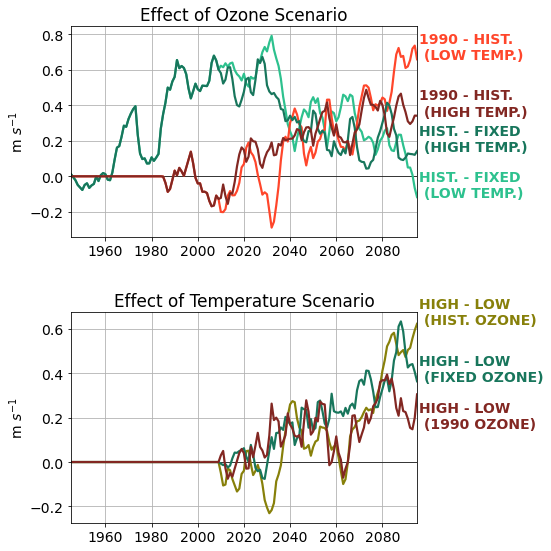

In [34]:
# 0 is summer 1 is winter
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]

tf = [0,0,0,0,1,0]
tf2 = [0,0,0.15,0,1,0]

higho3_min_Ro3_lowco2 = ar_1A-ar_2A
lowo3_min_Ro3_lowco2 = ar_3A-ar_1A
higho3_min_Ro3_highco2 = ar_1B-ar_2B
lowo3_min_Ro3_highco2 = ar_3B-ar_1B

Ro3_highco2_min_lowco2 = ar_1B-ar_1A

toplt = [higho3_min_Ro3_lowco2, lowo3_min_Ro3_lowco2, higho3_min_Ro3_highco2, \
        lowo3_min_Ro3_highco2] #, Ro3_highco2_min_lowco2

label = ['HIST. - FIXED \n (LOW TEMP.)', '1990 - HIST. \n (LOW TEMP.)',
        'HIST. - FIXED \n (HIGH TEMP.)', '1990 - HIST. \n (HIGH TEMP.)',]
    #'[CO$_2$↑]-[CO$_2$↓] (O$_3$R)'

cols = [sc.scen['2A']['color'],sc.scen['3A']['color'],\
       sc.scen['2B']['color'],sc.scen['3B']['color'],
       sc.scen['1B']['color']]
        
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].axhline(y=0, color = 'k', linewidth = 0.7)
for i in range(0,4):
#     if i <2:
#         lw = 3.5
#     else:
#         lw = 1.7
    
#     if i < 2:
        
    tplt = toplt[i][0,:]
    tnam = sc.scen[scens[i]]['name']
    tlab = label[i]
    axs[0].plot(np.arange(1944,2096,1),moving_average(tplt,10),\
             color = cols[i], linewidth = lw, linestyle = '-',\
            label = tlab)
    axs[0].text(2096,moving_average(tplt,10)[151]-tf[i], label[i],\
             color =  cols[i], fontweight = 'bold')
    
axs[0].grid()
axs[0].set_xlim(1945,2095)
axs[0].set_ylabel('m $s^{-1}$')
axs[0].set_title('Effect of Ozone Scenario')



Ro3_highco2_min_lowco2 = ar_1B-ar_1A
Fo3_highco2_min_lowco2 = ar_2B-ar_2A
No3_highco2_min_lowco2 = ar_3B-ar_3A

toplt = [Ro3_highco2_min_lowco2, Fo3_highco2_min_lowco2, No3_highco2_min_lowco2]
cols = [sc.scen['1B']['color'],sc.scen['2B']['color'],\
       sc.scen['3B']['color'],sc.scen['3B']['color'],
       ]
label = ['HIGH - LOW \n (HIST. OZONE)', 'HIGH - LOW \n (FIXED OZONE)',
        'HIGH - LOW \n (1990 OZONE)', '1990 - HIST. \n (HIGH TEMP.)',]

axs[1].axhline(y=0, color = 'k', linewidth = 0.7)
for i in range(0,3):
#     if i <2:
#         lw = 3.5
#     else:
#         lw = 1.7
    
#     if i < 2:
        
    tplt = toplt[i][0,:]
    tnam = sc.scen[scens[i]]['name']
    tlab = label[i]
    axs[1].plot(np.arange(1944,2096,1),moving_average(tplt,10),\
             color = cols[i], linewidth = lw, linestyle = '-',\
            label = tlab)
    axs[1].text(2096,moving_average(tplt,10)[151]-tf2[i], label[i],\
             color =  cols[i], fontweight = 'bold')
    
axs[1].grid()
axs[1].set_xlim(1945,2095)
axs[1].set_ylabel('m $s^{-1}$')
axs[1].set_title('Effect of Temperature Scenario')

fig.tight_layout(pad=2.4)
#fig.savefig(f'{pdir}/fx_10yrmean.jpg', dpi = 250)

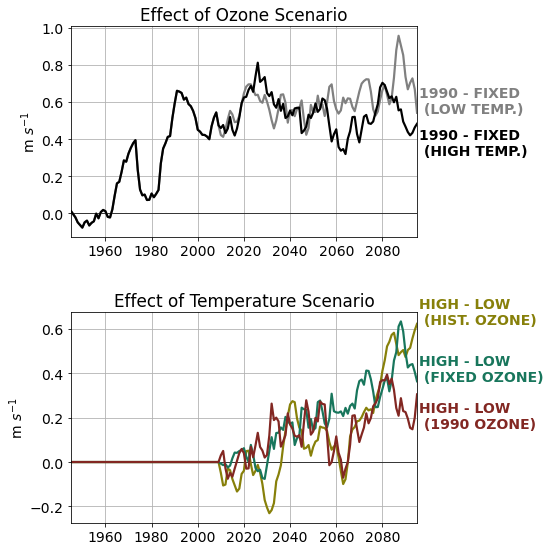

In [45]:
# 0 is summer 1 is winter
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]

tf = [0,0,0,0,1,0]
tf2 = [0,0,0.15,0,1,0]
tf3 = [0,.17,0,0,1,0]
higho3_min_Ro3_lowco2 = ar_1A-ar_2A
lowo3_min_Ro3_lowco2 = ar_3A-ar_1A
higho3_min_Ro3_highco2 = ar_1B-ar_2B
lowo3_min_Ro3_highco2 = ar_3B-ar_1B

Ro3_highco2_min_lowco2 = ar_1B-ar_1A

o3A_min_2A = ar_3A-ar_2A
o3B_min_2B = ar_3B-ar_2B

toplt = [higho3_min_Ro3_lowco2, lowo3_min_Ro3_lowco2, higho3_min_Ro3_highco2, \
        lowo3_min_Ro3_highco2] #, Ro3_highco2_min_lowco2
tplt2 = [ o3A_min_2A, o3B_min_2B]

label = ['HIST. - FIXED \n (LOW TEMP.)', '1990 - HIST. \n (LOW TEMP.)',
        'HIST. - FIXED \n (HIGH TEMP.)', '1990 - HIST. \n (HIGH TEMP.)',]

label = ['1990 - FIXED \n (LOW TEMP.)', '1990 - FIXED \n (HIGH TEMP.)',
        'HIST. - FIXED \n (HIGH TEMP.)', '1990 - HIST. \n (HIGH TEMP.)',]


cols = [sc.scen['2A']['color'],sc.scen['3A']['color'],\
       sc.scen['2B']['color'],sc.scen['3B']['color'],
       sc.scen['1B']['color']]

cols2 = ['grey', 'k']
        
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].axhline(y=0, color = 'k', linewidth = 0.7)
for i in range(0,2):
#     if i <2:
#         lw = 3.5
#     else:
#         lw = 1.7
    
#     if i < 2:
        
    tplt = tplt2[i][0,:]
    tnam = sc.scen[scens[i]]['name']
    tlab = label[i]
    axs[0].plot(np.arange(1944,2096,1),moving_average(tplt,10),\
             color = cols2[i], linewidth = lw, linestyle = '-',\
            label = tlab)
    axs[0].text(2096,moving_average(tplt,10)[151]-tf3[i], label[i],\
             color =  cols2[i], fontweight = 'bold')
    
axs[0].grid()
axs[0].set_xlim(1945,2095)
axs[0].set_ylabel('m $s^{-1}$')
axs[0].set_title('Effect of Ozone Scenario')



Ro3_highco2_min_lowco2 = ar_1B-ar_1A
Fo3_highco2_min_lowco2 = ar_2B-ar_2A
No3_highco2_min_lowco2 = ar_3B-ar_3A

toplt = [Ro3_highco2_min_lowco2, Fo3_highco2_min_lowco2, No3_highco2_min_lowco2]
cols = [sc.scen['1B']['color'],sc.scen['2B']['color'],\
       sc.scen['3B']['color'],sc.scen['3B']['color'],
       ]
label = ['HIGH - LOW \n (HIST. OZONE)', 'HIGH - LOW \n (FIXED OZONE)',
        'HIGH - LOW \n (1990 OZONE)', '1990 - HIST. \n (HIGH TEMP.)',]

axs[1].axhline(y=0, color = 'k', linewidth = 0.7)
for i in range(0,3):
#     if i <2:
#         lw = 3.5
#     else:
#         lw = 1.7
    
#     if i < 2:
        
    tplt = toplt[i][0,:]
    tnam = sc.scen[scens[i]]['name']
    tlab = label[i]
    axs[1].plot(np.arange(1944,2096,1),moving_average(tplt,10),\
             color = cols[i], linewidth = lw, linestyle = '-',\
            label = tlab)
    axs[1].text(2096,moving_average(tplt,10)[151]-tf2[i], label[i],\
             color =  cols[i], fontweight = 'bold')
    
axs[1].grid()
axs[1].set_xlim(1945,2095)
axs[1].set_ylabel('m $s^{-1}$')
axs[1].set_title('Effect of Temperature Scenario')

fig.tight_layout(pad=2.4)
#fig.savefig(f'{pdir}/fx_10yrmean.jpg', dpi = 250)

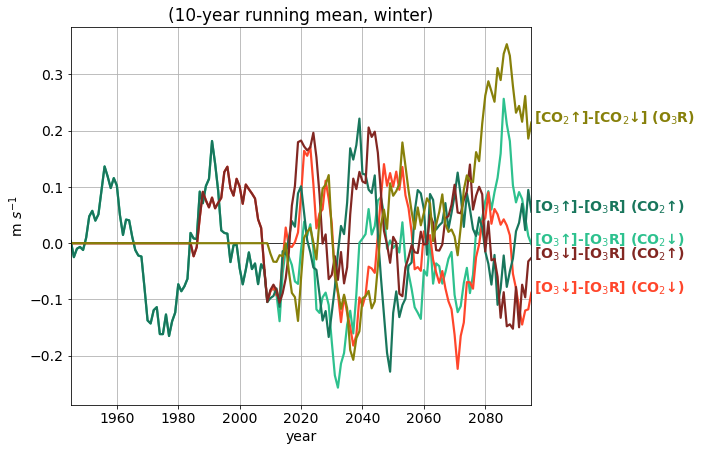

In [35]:
# 0 is summer 1 is winter
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]

tf = [0,0,0,0,0.0,0]

higho3_min_Ro3_lowco2 = ar_2A-ar_1A
lowo3_min_Ro3_lowco2 = ar_3A-ar_1A
higho3_min_Ro3_highco2 = ar_2B-ar_1B
lowo3_min_Ro3_highco2 = ar_3B-ar_1B

Ro3_highco2_min_lowco2 = ar_1B-ar_1A

toplt = [higho3_min_Ro3_lowco2, lowo3_min_Ro3_lowco2, higho3_min_Ro3_highco2, \
        lowo3_min_Ro3_highco2, Ro3_highco2_min_lowco2]

label = ['[O$_3$↑]-[O$_3$R] (CO$_2$↓)', '[O$_3$↓]-[O$_3$R] (CO$_2$↓)',
        '[O$_3$↑]-[O$_3$R] (CO$_2$↑)', '[O$_3$↓]-[O$_3$R] (CO$_2$↑)',\
        '[CO$_2$↑]-[CO$_2$↓] (O$_3$R)']

cols = [sc.scen['2A']['color'],sc.scen['3A']['color'],\
       sc.scen['2B']['color'],sc.scen['3B']['color'],
       sc.scen['1B']['color']]
        
fact = 0.7
fig, axs = plt.subplots(1,1, figsize=(15*fact, 10*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

axs.axhline(y=0, color = 'k', linewidth = 0.7)
for i in range(0,5):
#     if i <2:
#         lw = 3.5
#     else:
#         lw = 1.7
    
#     if i < 2:
        
    tplt = toplt[i][1,:]
    tnam = sc.scen[scens[i]]['name']
    tlab = label[i]
    axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
             color = cols[i], linewidth = lw, linestyle = '-',\
            label = tlab)
    axs.text(2096,moving_average(tplt,10)[151]-tf[i], label[i],\
             color =  cols[i], fontweight = 'bold')
#     tplt = toplt[i][1,:]
#     tnam = sc.scen[scens[i]]['name']
#     axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
#              color = cols[i], linewidth = lw, linestyle = ':',\
#             label = f'{tnam} (winter)')
    
axs.grid()
axs.set_xlim(1945,2095)
axs.set_ylabel('m $s^{-1}$')
axs.set_xlabel('year')
axs.set_title('(10-year running mean, winter)')
fig.tight_layout(pad=2.4)
fig.savefig(f'{pdir}/fx_10yrmean_winter.jpg', dpi = 250)

In [36]:
labs = []
for i in range(0,6):
    tnam = sc.scen[scens[i]]['name']
    labs.append(tnam)
    
print(labs)

['HIST.OZONE \n LOW TEMP.', 'HIST. OZONE \n HIGH TEMP.', 'FIXED OZONE \n LOW TEMP.', 'FIXED OZONE \n HIGH TEMP.', '1990 OZONE \n LOW TEMP.', '1990 OZONE \n HIGH TEMP.']


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


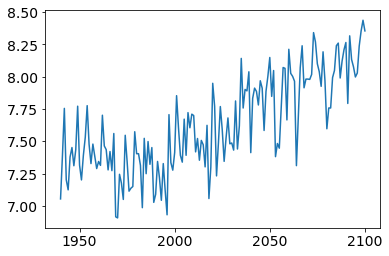

In [37]:
# plt.plot(np.arange(1940,2101,1),ar_1B[0,:])
plt.plot(np.arange(1940,2101,1),ar_2B[0,:])
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
ar_1A[:,30]=ar_1A[:,29];
ar_1B[:,30]=ar_1B[:,29];
ar_2A[:,41]=ar_2A[:,40];
ar_2B[:,41]=ar_2B[:,40];
ar_2B[:,142]=ar_2B[:,141];
ar_3A[:,30]=ar_3A[:,29];
ar_3B[:,30]=ar_3B[:,29];
for i in range(0,6):
    print(np.where(np.isnan(scen_ars[i][0,:])))